Se importan las librerías necesarias para el manejo de archivos, visualización de datos, manipulación y preprocesamiento de datos, modelado, análisis geoespacial y evaluación de modelos. Se establece una semilla aleatoria para asegurar la reproducibilidad de los resultados. Además, se configuran algunos parámetros predeterminados para las visualizaciones con Matplotlib y Seaborn.

In [1]:
# Manejo de archivos y directorios
from pathlib import Path
import joblib

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulación de datos
import numpy as np
import pandas as pd
import random

# Preprocesamiento de datos
from transformers import CleanTransformer, EncodeTransformer, ImputeTransformer,LabelEncodingTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Selección de características y evaluación de modelos
from sklearn.model_selection import cross_val_score

# Modelos de regresión
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# Análisis geoespacial
import folium
from folium.plugins import HeatMap

# Estadística y econometría
import statsmodels.api as sm

# Evaluación del modelo
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
randomSeed=13
np.random.seed(randomSeed)

In [3]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Evolucion dataframe original

In [4]:
codigo_dir = Path.cwd()

anexos_dir = codigo_dir.parent
data_dir = anexos_dir.parent / "Datos"

df_org = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test=pd.read_csv(data_dir / "test.csv", index_col="Id")

Eliminado de columnas de año de venta y mes de venta

In [5]:
df_org=df_org.drop(columns=['MoSold','YrSold'],axis=1)
df_test=df_test.drop(columns=['MoSold','YrSold'],axis=1)

Se agrega una variable direccion, latitud y longitud al dataset original para añadir novedad y funcionalidad

In [6]:
# Fusion de datasets
houses_data=data = pd.read_csv(data_dir/ 'housing.csv', sep=',', header=0)

In [7]:
houses_data= houses_data[['latitude','longitude']]

In [8]:
unique_locations = houses_data[['latitude', 'longitude']].drop_duplicates()
unique_locations = unique_locations.to_records(index=False).tolist()

In [9]:
random_locations = np.random.choice(len(unique_locations), size=len(df_org))
df_org[['Latitude', 'Longitude']] = [unique_locations[i] for i in random_locations]
random_locations_test = np.random.choice(len(unique_locations), size=len(df_test))
df_test[['Latitude', 'Longitude']] = [unique_locations[i] for i in random_locations_test]

Añadir direcciones

In [10]:
# Crear nombres de calles ficticias
street_names = ['Oak St.', 'Maple Ave.', 'Pine Dr.', 'Cedar Ln.', 'Birch Blvd.', 'Elm St.', 'Willow Rd.']

# Crear un conjunto para verificar direcciones únicas
used_addresses = set()

# Crear función para generar una dirección única
def generate_unique_address(neighborhood, index):
    while True:
        street = random.choice(street_names)
        house_number = random.randint(1, 9999)  # Puedes ajustar el rango según el barrio
        address = f"{house_number} {street}, {neighborhood}"
        if address not in used_addresses:
            used_addresses.add(address)
            return address

# Aplicar la función a cada fila del DataFrame
df_org['Address'] = df_org.apply(lambda row: generate_unique_address(row['Neighborhood'], row.name), axis=1)
df_test['Address']= df_test.apply(lambda row: generate_unique_address(row['Neighborhood'], row.name), axis=1)

In [11]:
# Establecer la columna 'Address' como índice
df_org.set_index('Address', inplace=True)
df_org.head()
df_test.set_index('Address', inplace=True)

In [12]:
df_combined = pd.concat([df_org, df_test], axis=0, sort=False)
df_combined.to_csv(data_dir / 'test_distances.csv', index=True)

In [13]:
df_combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,SalePrice,Latitude,Longitude
Address,,,,,,,,,,,,,,,,,,,,,
"7089 Willow Rd., CollgCr",60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,WD,Normal,208500.0,37.54,-121.93
"68 Oak St., Veenker",20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,WD,Normal,181500.0,37.77,-122.21
"5939 Maple Ave., CollgCr",60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,WD,Normal,223500.0,34.11,-117.63
"4944 Elm St., Crawfor",70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,WD,Abnorml,140000.0,40.57,-122.34
"483 Willow Rd., NoRidge",60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,WD,Normal,250000.0,37.76,-121.97


# Creacion de pipeline

Se lleva a cabo una serie de pasos para preparar los datos (`df_org`) antes de construir un modelo predictivo. A continuación, se describe cada parte del código y su función:

### 1. Definición de variables y niveles de ordenación

Primero, se definen algunas listas y un diccionario para manejar variables categóricas y ordinales en el DataFrame:

- **`nom_var`**: Lista de nombres de variables categóricas (nominales) que serán tratadas durante el preprocesamiento.
- **`grade_lvls`**: Lista que contiene los niveles de calidad ordinal (por ejemplo, "Po", "Fa", "TA", "Gd", "Ex").
- **`number_lvls`**: Lista de niveles numéricos del 1 al 10.

Además, se define un diccionario **`ordered_levels`** para especificar el orden de los niveles en variables ordinales. Para cada clave en el diccionario, se añaden niveles ordenados correspondientes a características específicas (por ejemplo, `OverallQual`, `OverallCond`, `ExterQual`, etc.). El diccionario es modificado para incluir un nivel adicional "None" al principio de cada lista de niveles.

### 2. Creación del pipeline de preprocesamiento

A continuación, se crea un pipeline de preprocesamiento utilizando la clase `Pipeline` de `sklearn`. Este pipeline consta de tres transformadores personalizados:

- **`CleanTransformer`**: Se utiliza para limpiar los datos.
- **`EncodeTransformer`**: Transforma las variables categóricas nominales y ordinales de acuerdo con las listas y diccionarios definidos anteriormente.
- **`ImputeTransformer`**: Imputa los valores faltantes en el conjunto de datos.

### 3. Escalado de la variable objetivo

La variable objetivo `SalePrice` es extraída del DataFrame original (`df_org`) y escalada utilizando `StandardScaler` de `sklearn`. 

- **`y_scaler`**: Es el objeto `StandardScaler` que se ajusta (`fit`) a los valores de `y` (la variable objetivo) y luego se guarda como un archivo `.pkl` para su uso posterior.
- **`y_scaled`**: Es la variable objetivo escalada que se transforma utilizando el `y_scaler`.

### 4. Transformación del DataFrame original

Finalmente, el pipeline de preprocesamiento `pipeline_preProcess` se ajusta (`fit`) y transforma (`transform`) al DataFrame original (`df_org`), produciendo un nuevo DataFrame preprocesado, **`df_preProcessed`**.

Este proceso prepara el conjunto de datos para la siguiente fase de modelado, asegurando que todas las variables estén correctamente escaladas, imputadas, y codificadas.


In [14]:
# Definimos las variables
nom_var = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

grade_lvls = ["Po", "Fa", "TA", "Gd", "Ex"]
number_lvls = list(range(1, 11))

ordered_levels = {
    "OverallQual": number_lvls,
    "OverallCond": number_lvls,
    "ExterQual": grade_lvls,
    "ExterCond": grade_lvls,
    "BsmtQual": grade_lvls,
    "BsmtCond": grade_lvls,
    "HeatingQC": grade_lvls,
    "KitchenQual": grade_lvls,
    "FireplaceQu": grade_lvls,
    "GarageQual": grade_lvls,
    "GarageCond": grade_lvls,
    "PoolQC": grade_lvls,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()}


# Creamos el pipeline
pipeline_preProcess = Pipeline([
    ('clean', CleanTransformer()),
    ('encode', EncodeTransformer(nominal_vars=nom_var, ordered_levels=ordered_levels)),
    ('impute', ImputeTransformer()),
])

y=df_org.pop('SalePrice')
y_scaler = StandardScaler()
y_scaler = y_scaler.fit(y.values.reshape(-1, 1))
joblib.dump(y_scaler, Path.cwd()/ 'pkls/y_scaler.pkl')
y_scaled= y_scaler.transform(y.values.reshape(-1, 1)).ravel()
# Llamar al método para calcular las distancias
df_preProcessed = pipeline_preProcess.fit_transform(df_org.copy())

In [15]:
df_preProcessed.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Latitude,Longitude
Address,,,,,,,,,,,,,,,,,,,,,
"7089 Willow Rd., CollgCr",60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,None,None,0,WD,Normal,37.54,-121.93
"68 Oak St., Veenker",20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,None,None,None,0,WD,Normal,37.77,-122.21
"5939 Maple Ave., CollgCr",60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,None,None,None,0,WD,Normal,34.11,-117.63
"4944 Elm St., Crawfor",70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,None,None,None,0,WD,Abnorml,40.57,-122.34
"483 Willow Rd., NoRidge",60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,None,None,None,0,WD,Normal,37.76,-121.97


In [16]:
column_types=[df_preProcessed.dtypes.unique]
column_types

[<bound method Series.unique of MSSubClass       category
 MSZoning         category
 LotFrontage       float64
 LotArea             int64
 Street           category
                    ...   
 MiscVal             int64
 SaleType         category
 SaleCondition    category
 Latitude          float64
 Longitude         float64
 Length: 79, dtype: object>]

# ANALISIS VISUAL

Se definen y ejecutan varias visualizaciones para analizar el DataFrame preprocesado (`df_preProcessed`). A continuación se describen las funciones y el propósito de cada visualización generada:

### 1. Matriz de correlación de variables

La primera visualización es una matriz de correlación que utiliza un `clustermap` de Seaborn para mostrar las relaciones entre las variables numéricas en el DataFrame:

- **`sns.clustermap`**: Se crea un mapa de clúster que representa la correlación entre las variables numéricas usando el método de correlación de Pearson.
- **Configuración**: La matriz se configura con un rango de valores entre -1 y 1 para la correlación, utilizando el colormap `viridis`. El método de agrupamiento es "complete" y las anotaciones no se muestran.

### 2. Boxplots de variables categóricas

Para cada variable categórica especificada en `categorical_vars_analysis`, se genera un boxplot que muestra la distribución de `SalePrice` para cada categoría:

- **`sns.boxplot`**: Se crea un boxplot donde la variable categórica se usa como el parámetro `hue` para colorear los datos.
- **Configuración**: Se configuran los títulos, etiquetas de los ejes, y la rotación de las etiquetas del eje x para mejorar la visibilidad. Se añade una cuadrícula ligera para una mejor visualización.

### 3. Histogramas de variables numéricas

Para cada variable numérica especificada en `numeric_vars_analysis`, se crea un histograma con una estimación de densidad (KDE):

- **`sns.histplot`**: Se crea un histograma con la opción KDE activada para mostrar la distribución de los datos. El color es `skyblue` con bordes negros, y se utiliza un número de 30 intervalos (bins).
- **Configuración**: Se ajustan los títulos y las etiquetas de los ejes, y se añade una cuadrícula ligera.

### 4. Gráficos de dispersión

Para cada variable en `scatter_vars_analysis`, se genera un gráfico de dispersión que ilustra la relación entre `SalePrice` y la variable seleccionada:

- **`plt.scatter`**: Se crea un gráfico de dispersión donde los puntos están coloreados según `SalePrice`, utilizando el colormap `viridis` para representar las variaciones de precio.
- **Configuración**: Se añade una barra de color para indicar la relación con `SalePrice`, y se configuran los títulos y las etiquetas de los ejes.

En resumen, estas visualizaciones proporcionan una comprensión detallada de las relaciones entre las variables en el conjunto de datos, facilitando el análisis de correlaciones, distribuciones y relaciones entre las variables numéricas y categóricas.


In [17]:
def create_graphics(df,categorical_vars_analysis=[],numeric_vars_analysis=[],scatter_vars_analysis=[]):
    # Matriz correlacion de variables 
    sns.clustermap(
            df.corr('pearson', numeric_only=True), # Solo se usan variables numericas
            vmin=-1.0,
            vmax=1.0,
            cmap="viridis",
            method="complete",
            annot=False
    )

    # Boxplot de variables
    for var in categorical_vars_analysis:
        plt.figure(figsize=(12, 8))
        # Configurar estilo de Seaborn
        sns.set(style='whitegrid')
        # Crear el boxplot con la variable categórica asignada al parámetro 'hue'
        sns.boxplot(x=var, y=y, data=df, hue=var, palette='Set2', linewidth=1.2, dodge=False)
        # Configurar el título y las etiquetas
        plt.title(f'Boxplot de SalePrice por {var}', fontsize=18, fontweight='bold')
        plt.xlabel(var, fontsize=14)
        plt.ylabel('SalePrice', fontsize=14)
        # Rotar las etiquetas del eje x para mejor visibilidad
        plt.xticks(rotation=45)
        # Agregar una cuadrícula ligera para mejor visualización
        plt.grid(True, linestyle='--', alpha=0.7)
        # No se necesita leyenda en este caso, así que no la incluimos
        plt.legend([], [], frameon=False)  # Asegura que no se intente dibujar la leyenda
        # Mostrar el gráfico
        plt.show()

    # Histogramas de variables numericas destacadas
    for var in numeric_vars_analysis:
        plt.figure(figsize=(10, 6))
        # Configurar estilo de Seaborn
        sns.set(style='whitegrid')
        # Crear el histograma con KDE
        sns.histplot(df[var], kde=True, color='skyblue', edgecolor='black', bins=30)
        # Configurar el título y las etiquetas
        plt.title(f'Histograma de {var}', fontsize=16, fontweight='bold')
        plt.xlabel(var, fontsize=14)
        plt.ylabel('Frecuencia', fontsize=14)
        # Agregar una cuadrícula ligera para mejor visualización
        plt.grid(True, linestyle='--', alpha=0.7)
        # Mostrar el gráfico
        plt.show()

    # Scatter plots para ver la relacion entre target y variables 
    for var in scatter_vars_analysis:
        plt.figure(figsize=(10, 6))
        # Crear el gráfico de dispersión
        plt.scatter(df[var], y, c=y, cmap='viridis', alpha=0.6, edgecolors='w')
        # Agregar la barra de color
        plt.colorbar(label='SalePrice')
        # Configurar el título y las etiquetas
        plt.title(f'Relación entre SalePrice y {var}')
        plt.xlabel(var)
        plt.ylabel('SalePrice')
        plt.show()


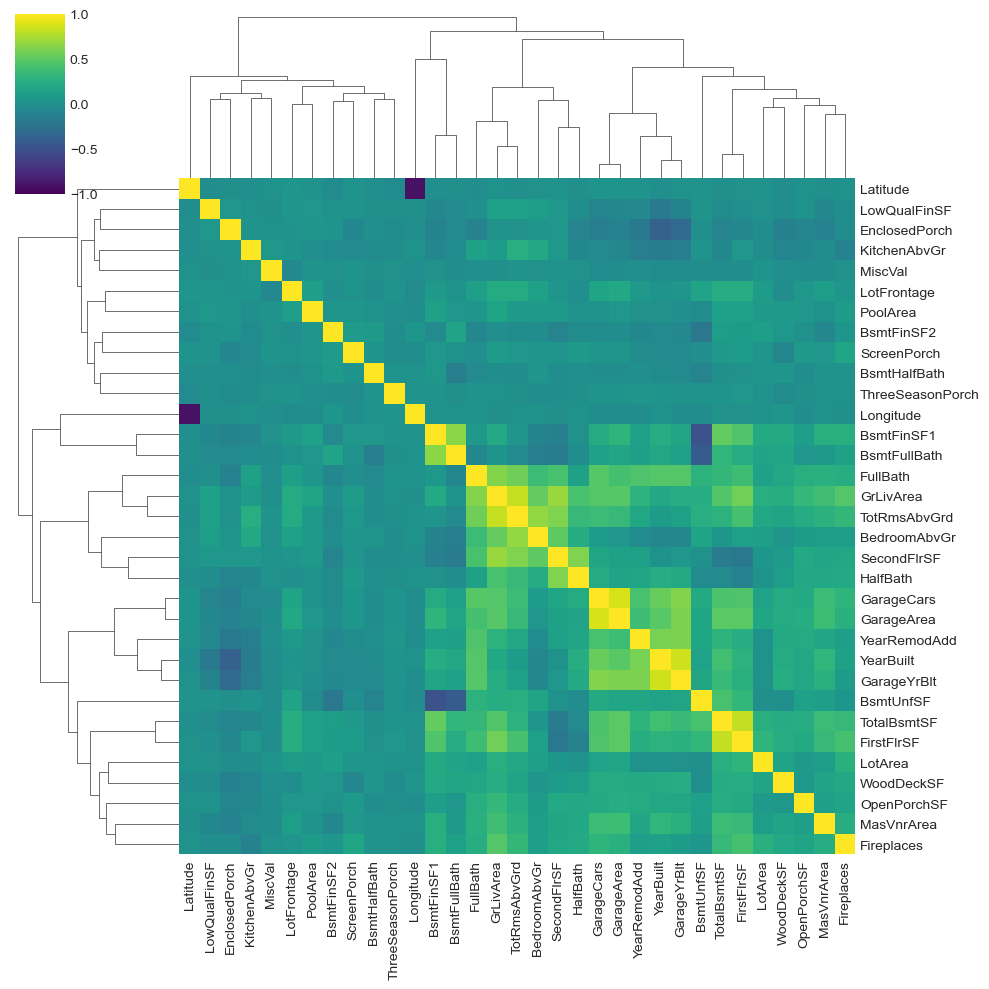

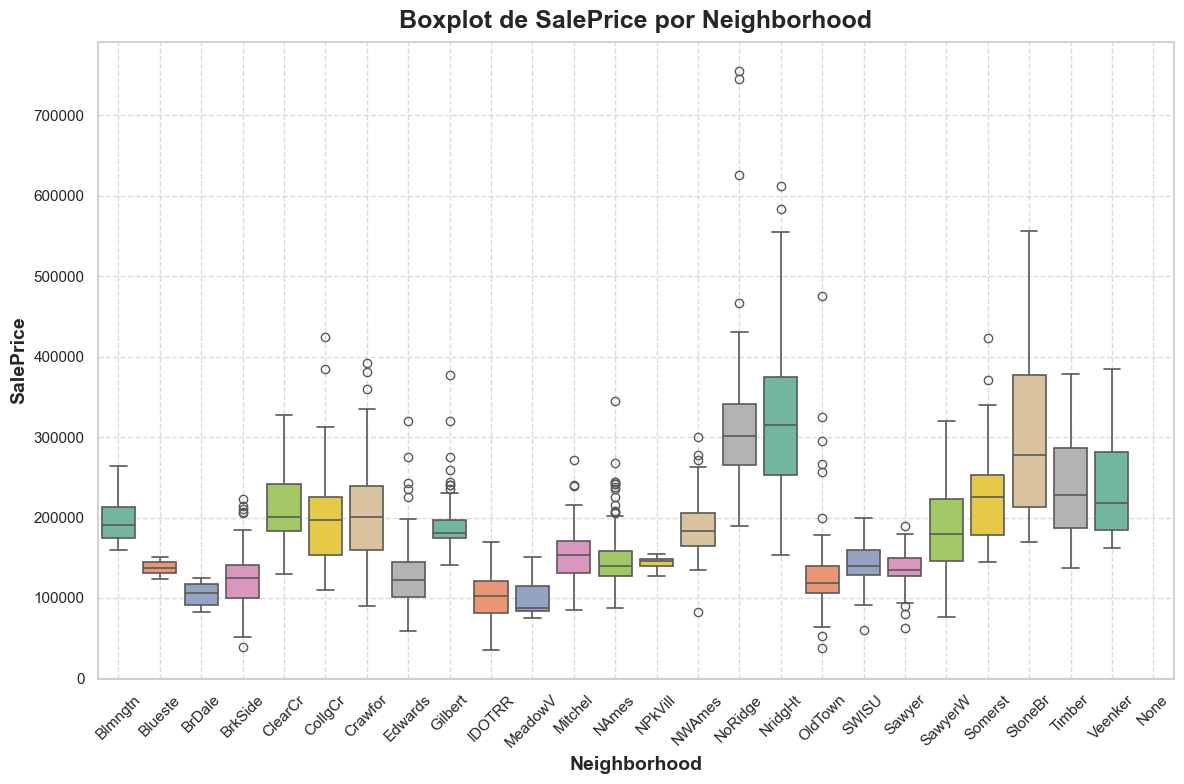

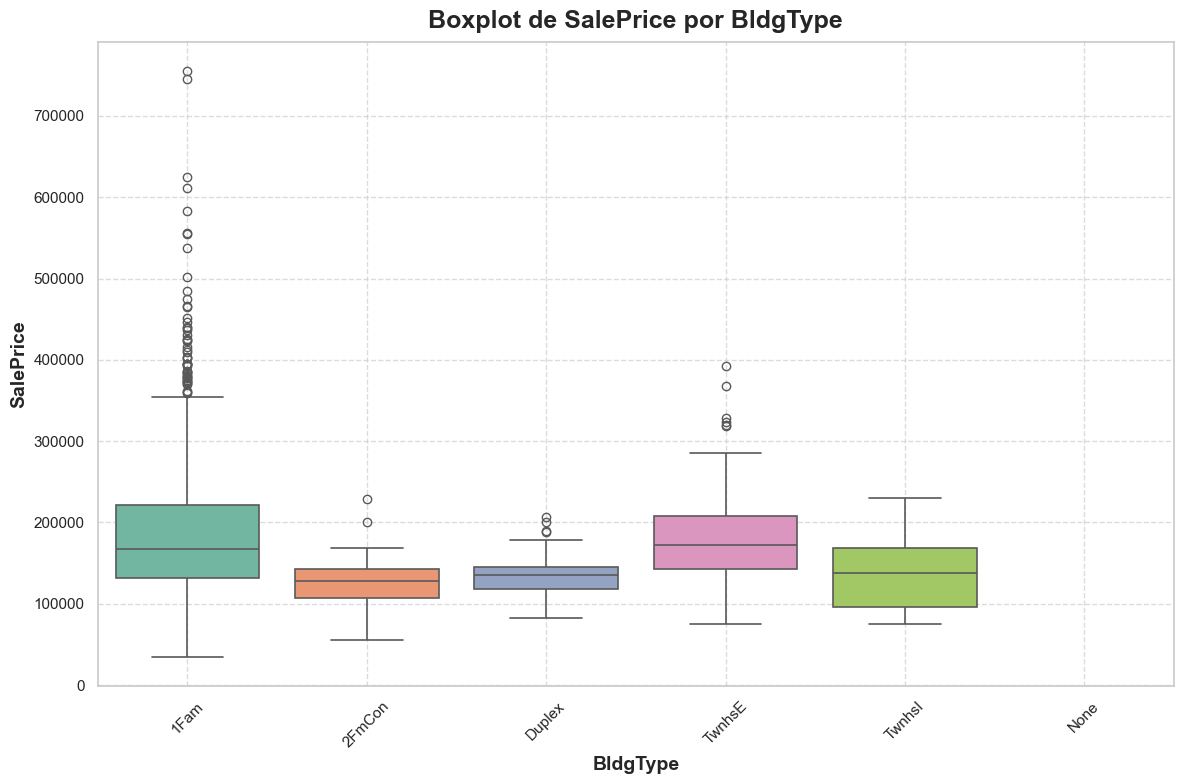

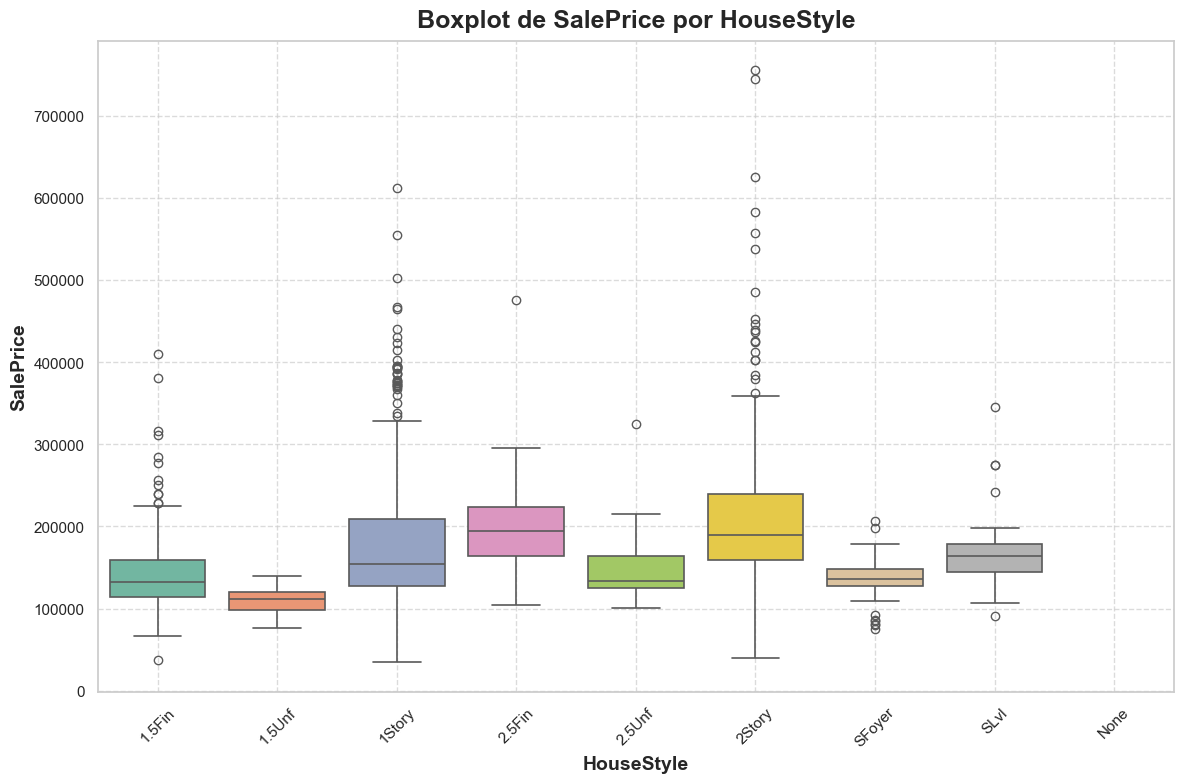

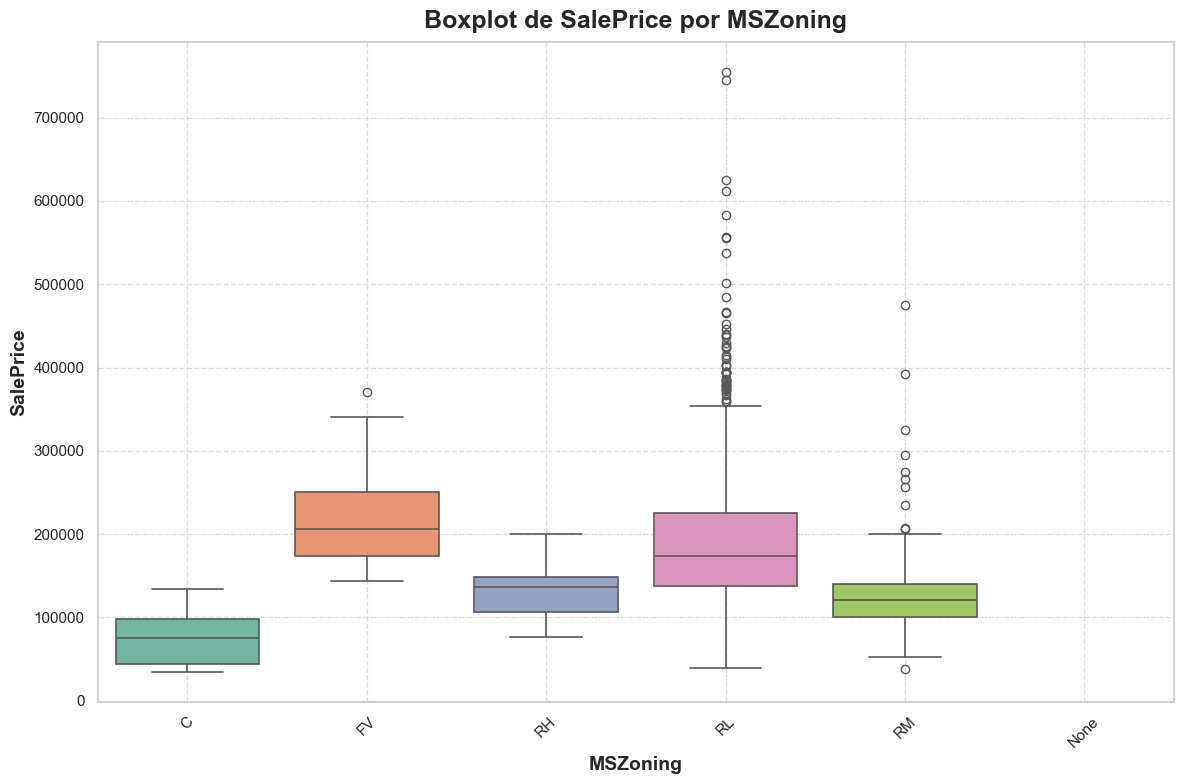

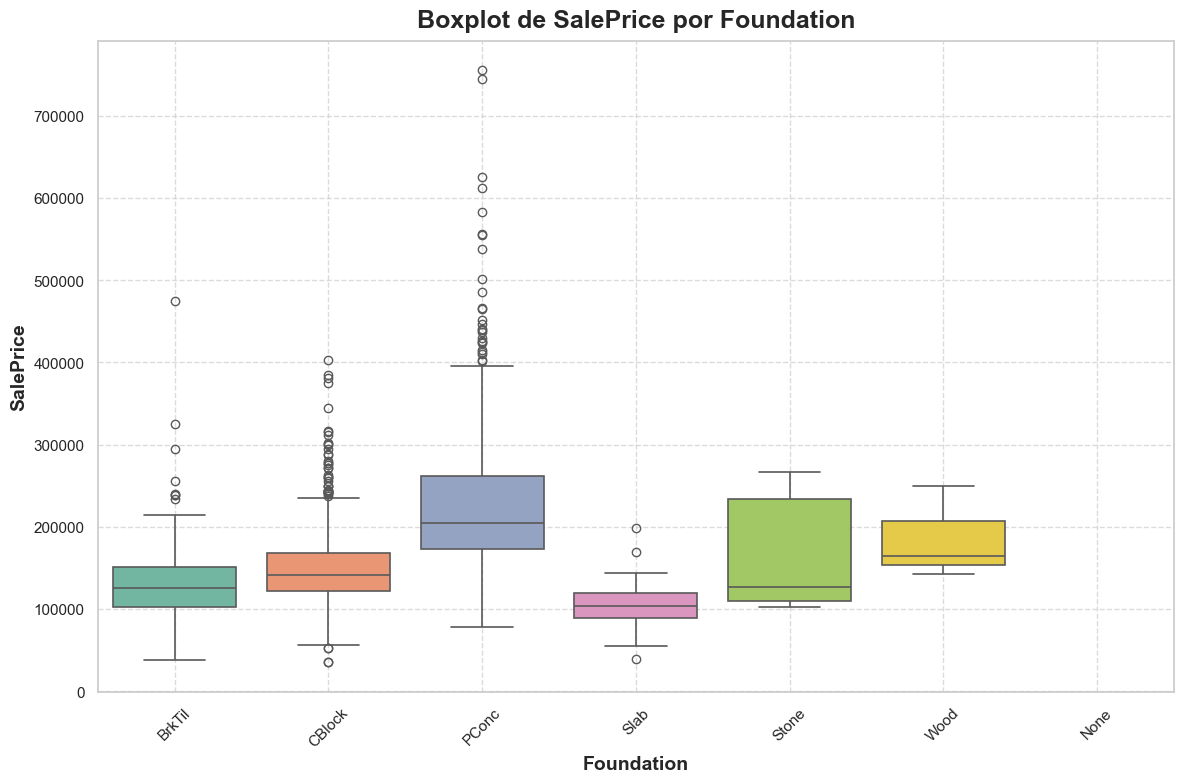

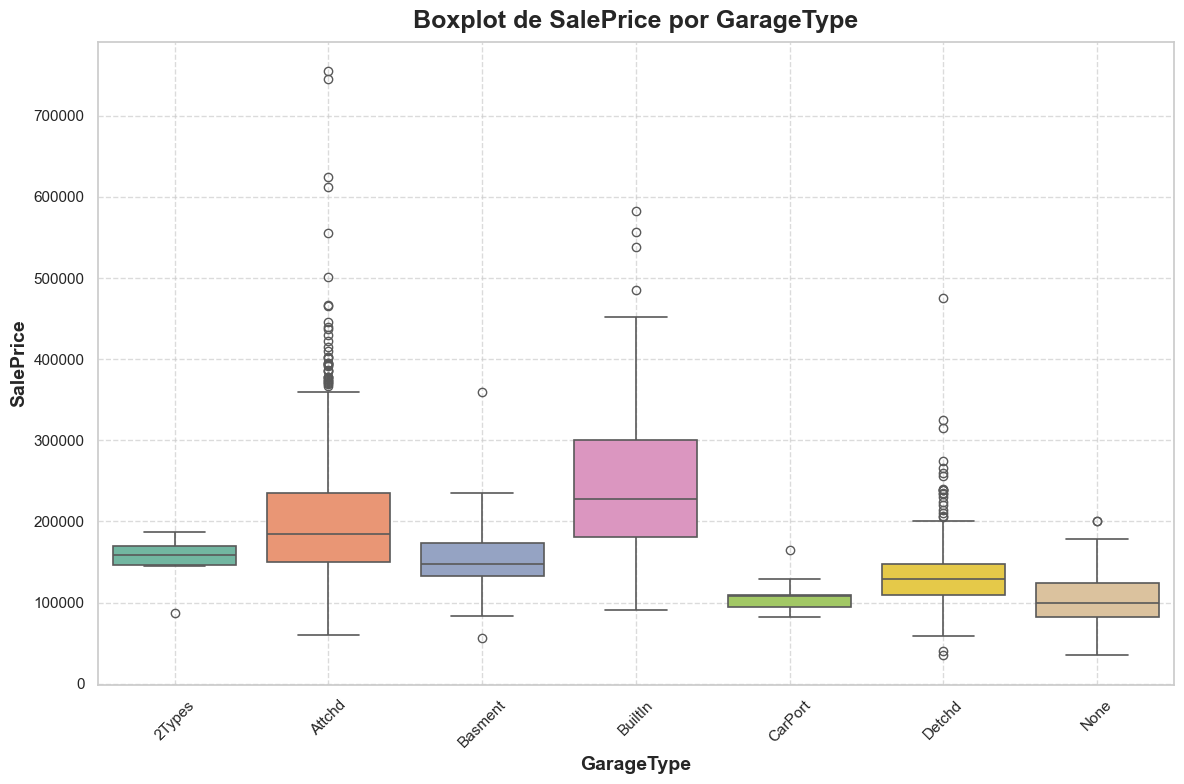

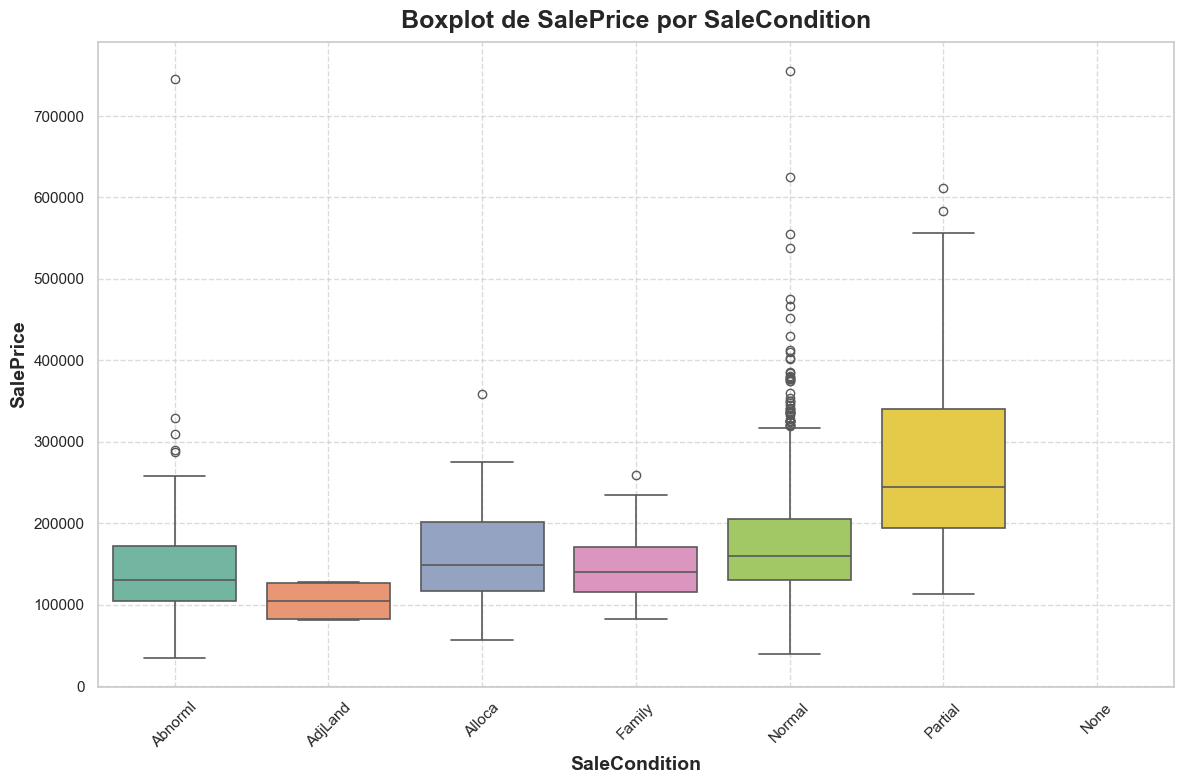

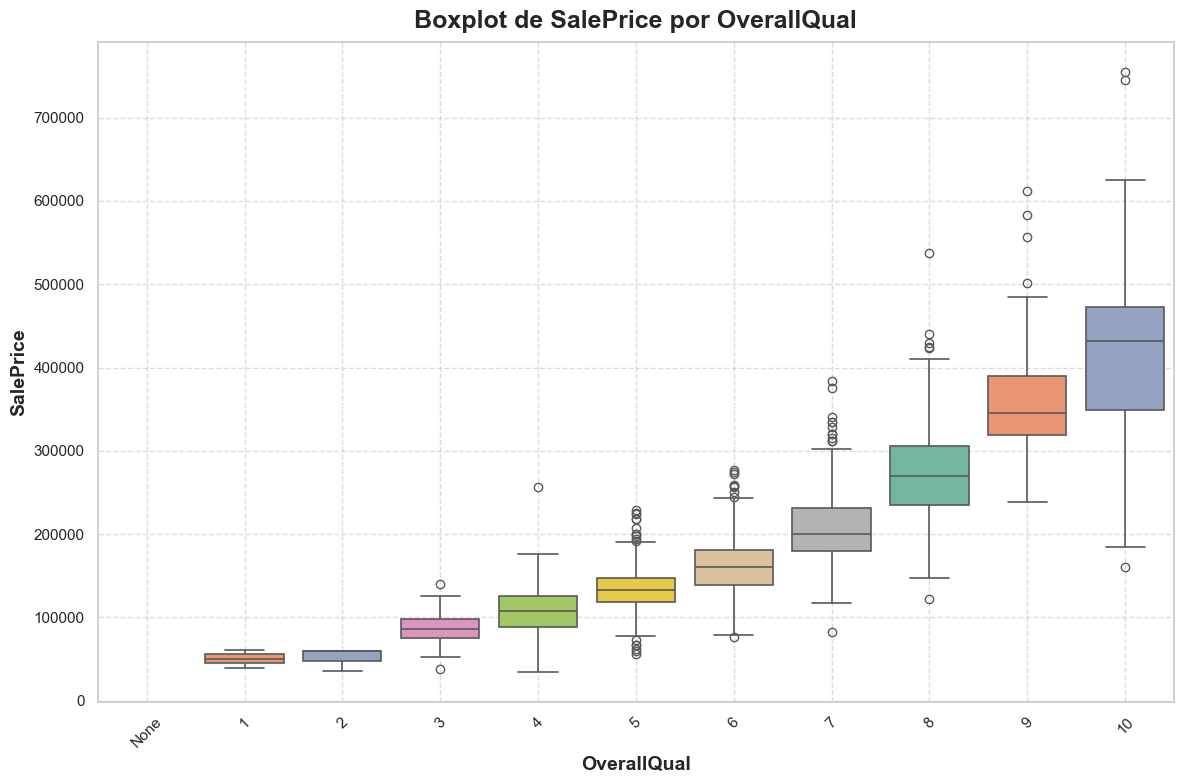

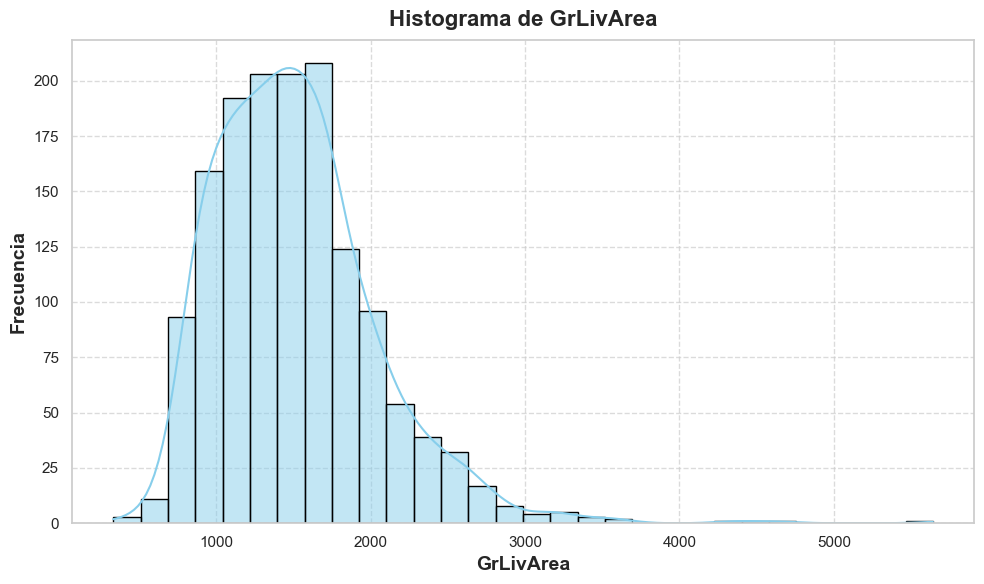

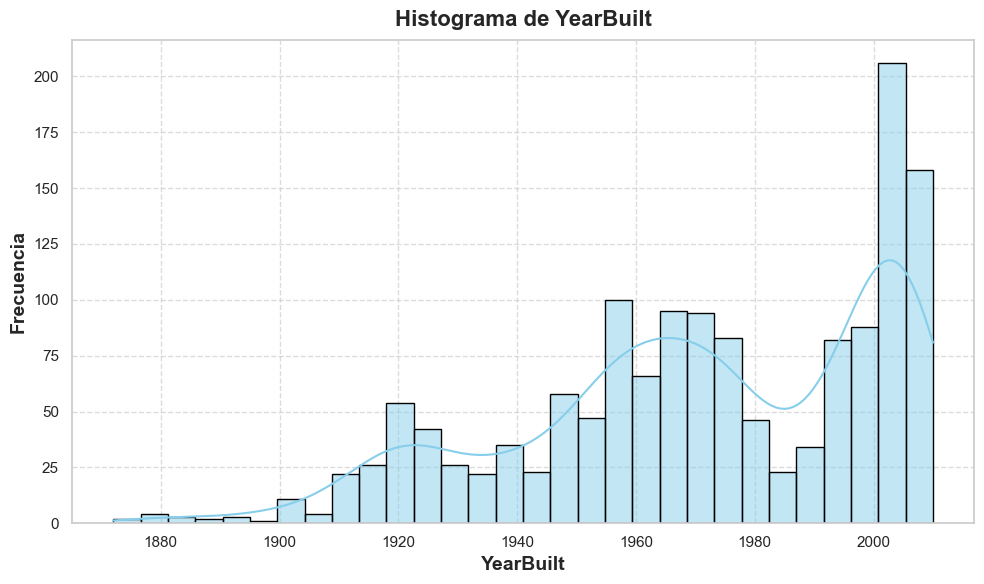

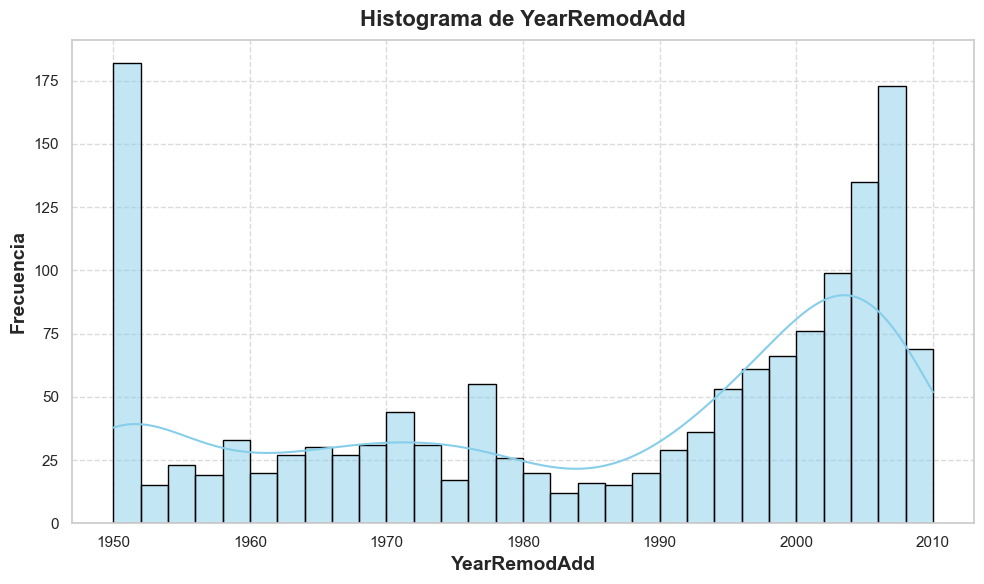

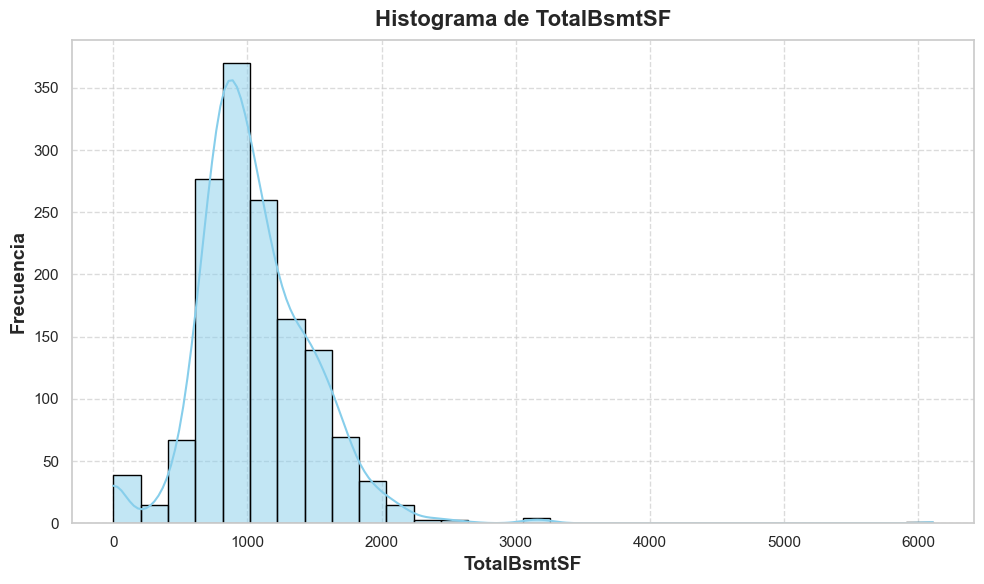

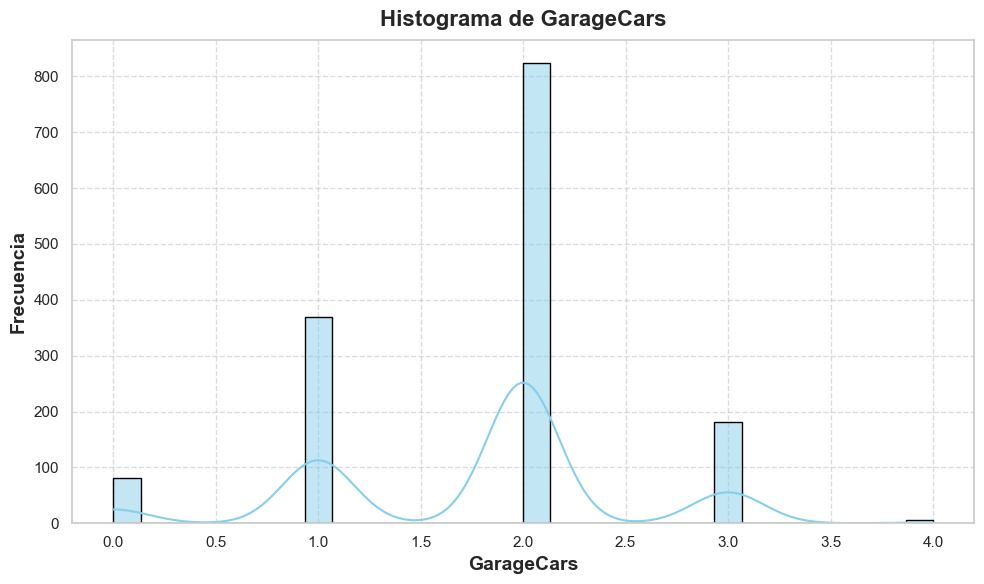

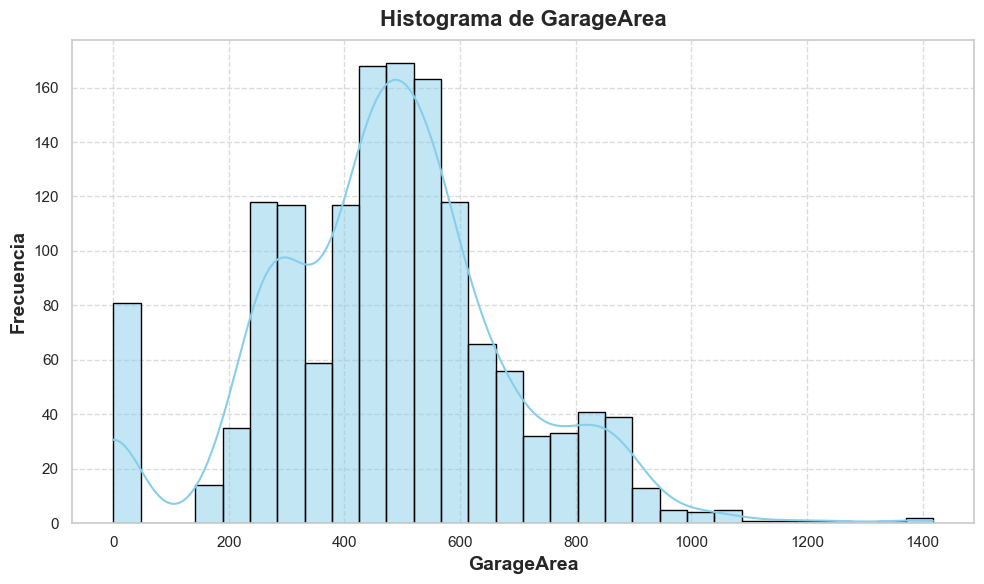

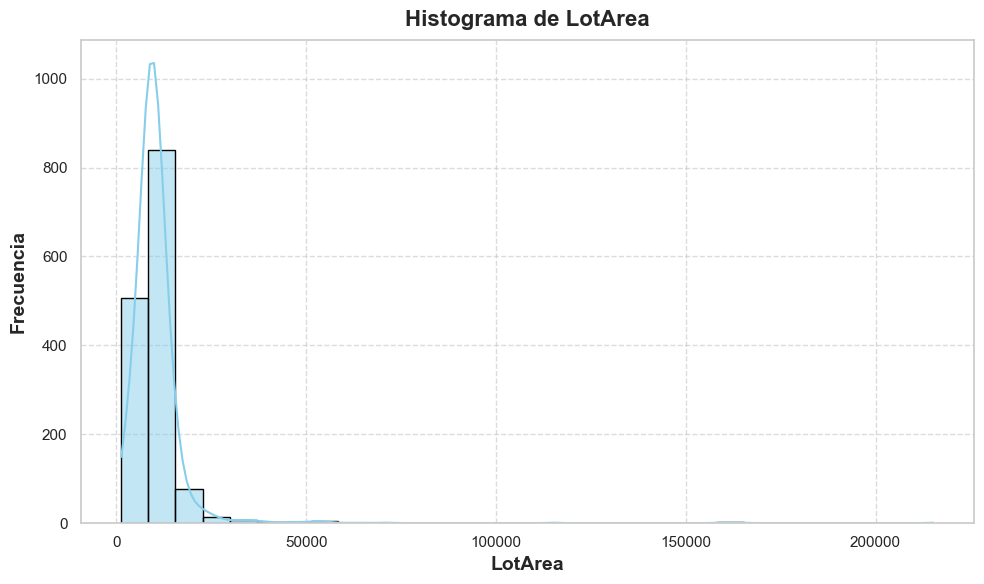

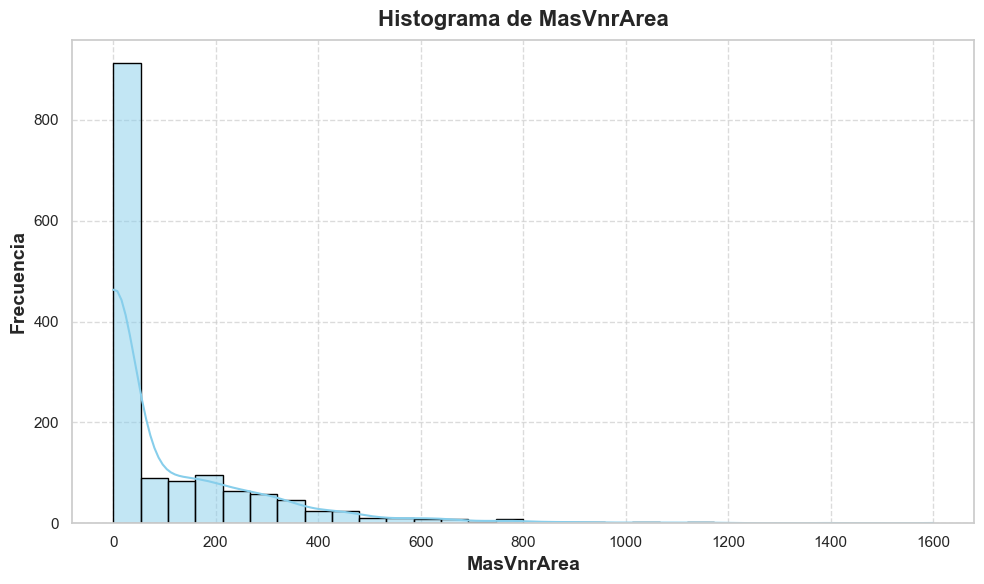

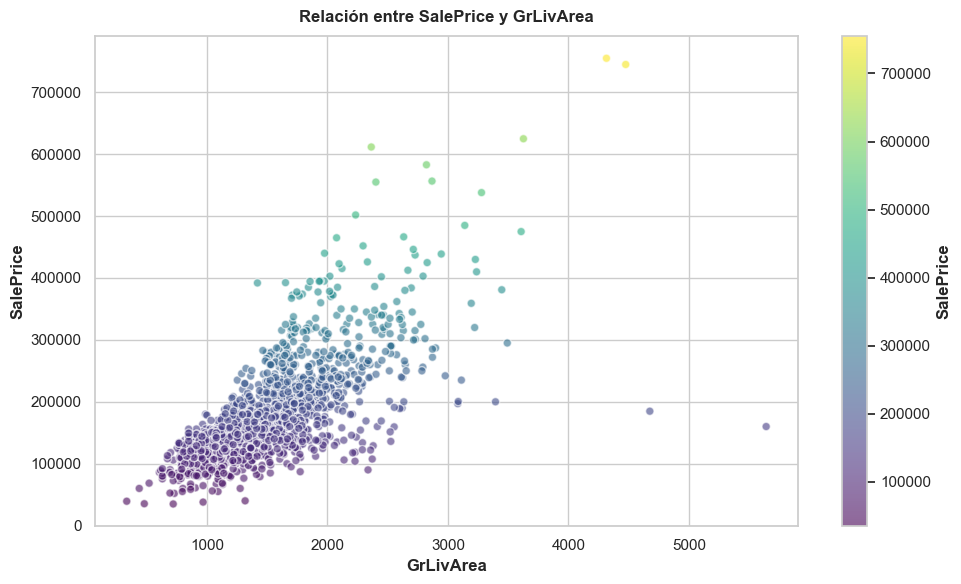

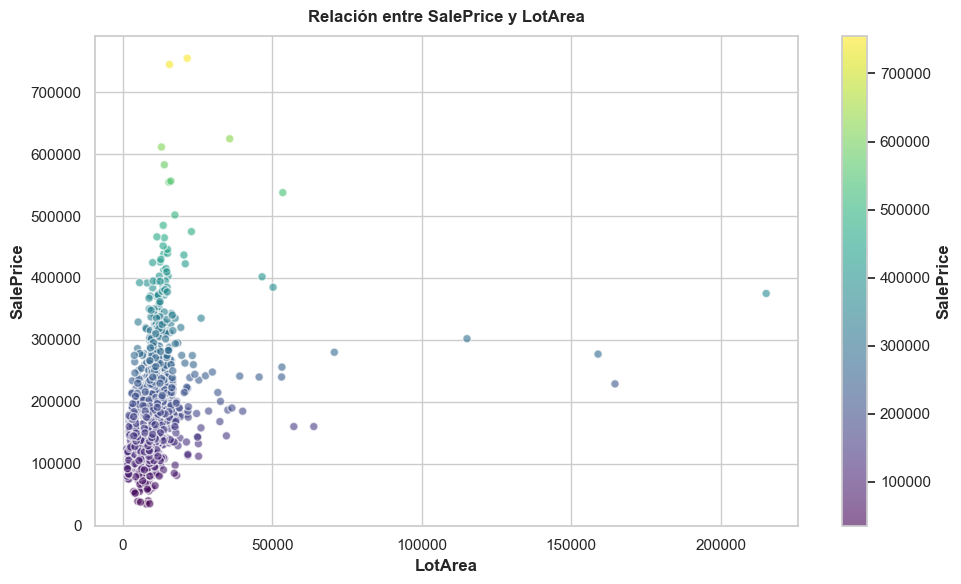

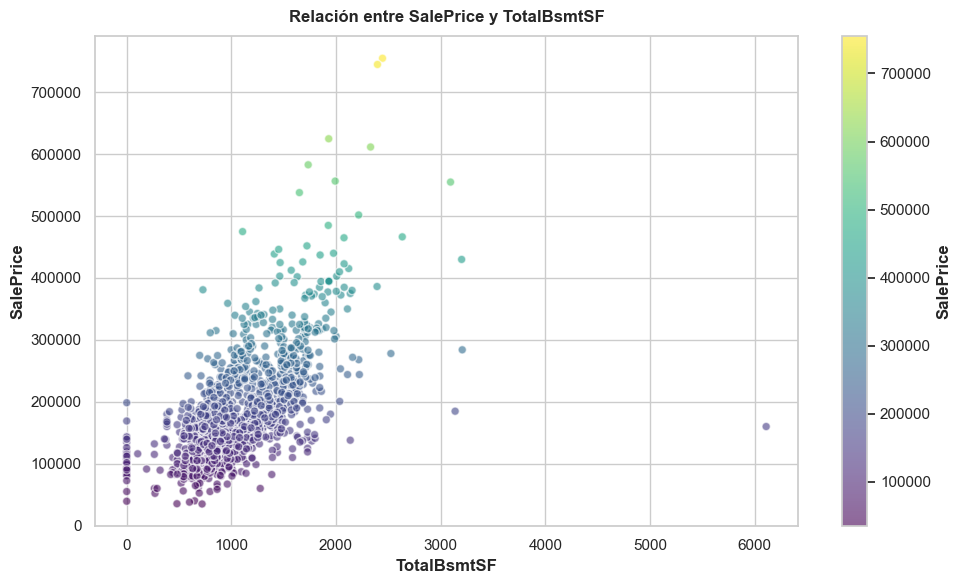

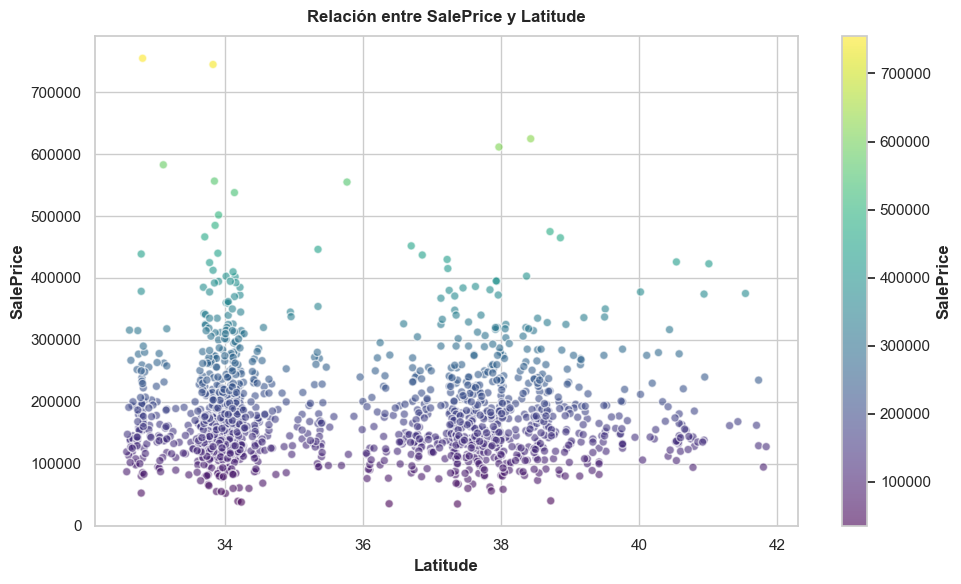

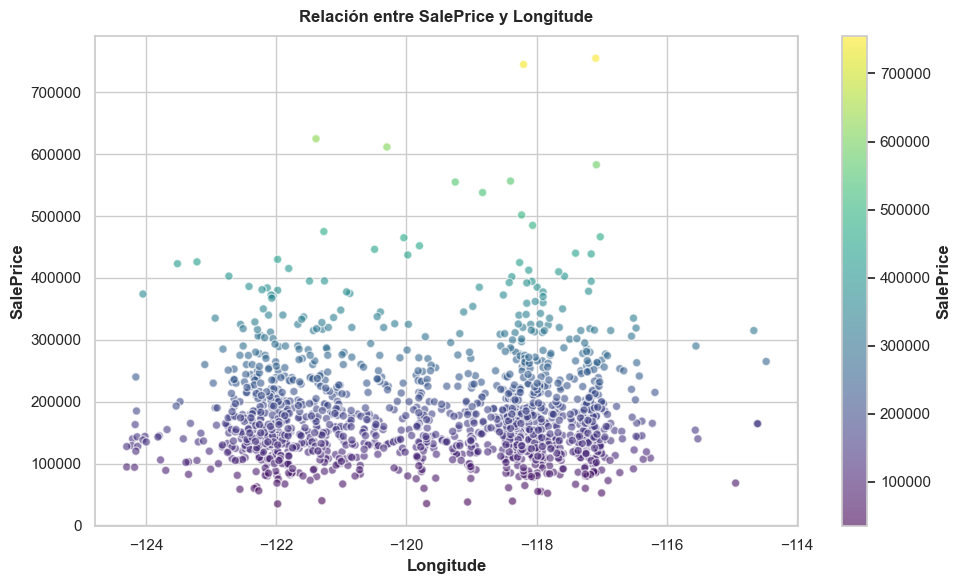

In [18]:
# Variables categóricas a analizar
categorical_vars_analysis = [
    'Neighborhood', 'BldgType', 'HouseStyle', 'MSZoning', 'Foundation', 'GarageType', 'SaleCondition','OverallQual'
]

# Variables numéricas a analizar
numeric_vars_analysis = [
    'GrLivArea', 'YearBuilt', 'YearRemodAdd', 
    'TotalBsmtSF', 'GarageCars', 'GarageArea','LotArea', 'MasVnrArea'
]
# Variables numéricas a analizar
scatter_vars_analysis = [
    'GrLivArea','LotArea','TotalBsmtSF', 'Latitude', 'Longitude'
]

create_graphics(df_preProcessed,categorical_vars_analysis,numeric_vars_analysis,scatter_vars_analysis)

# Definicion columnas

In [19]:
target="SalePrice"
categ_col = list(df_preProcessed.select_dtypes(include=['object', 'category']).columns)
num_col = list(df_preProcessed.select_dtypes(include=['number']).columns)
label_cols=list(ordered_levels.keys())

# Mapa de calor para analisis de latitud y longitud

Se realiza la preparación y visualización de datos geoespaciales para analizar la relación entre el precio de venta de las propiedades (`SalePrice`) y sus ubicaciones en un mapa. A continuación se detallan los pasos y propósitos de cada sección del código:

### Preparar los datos para la regresión

Se preparan las variables necesarias para ajustar un modelo de regresión lineal que predice el precio de venta (`SalePrice`) basado en las coordenadas geográficas:

- **Selección de Variables**: Se seleccionan las columnas `Latitude` y `Longitude` del DataFrame `df_preProcessed` para formar la matriz de características (`X_map`).
- **Añadir Intercepto**: Se añade una constante a `X_map` para incluir el término de intercepto en el modelo de regresión.
- **Definir Variable Objetivo**: Se define `y_map` como el vector de precios de venta (`y`).

### Ajustar el Modelo de Regresión

Se ajusta un modelo de regresión lineal para predecir `SalePrice` usando las coordenadas geográficas:

- **Ajuste del Modelo**: Se utiliza la regresión lineal ordinaria (OLS) de `statsmodels` para ajustar el modelo con `X_map` y `y_map`.

### Combinar Datos para el Mapa

Se combina el precio de venta con los datos preprocesados para la visualización en un mapa:

- **Combinar DataFrames**: Se copia `df_preProcessed` y se añade la columna `SalePrice` para crear `df_combined_map`.

### Crear y Visualizar el Mapa de Calor

Se crea un mapa base y se añade un mapa de calor para visualizar la distribución de `SalePrice` según la ubicación geográfica:

- **Crear Mapa Base**: Se inicializa un mapa de Folium centrado en la media de las coordenadas geográficas.
- **Preparar Datos para el Mapa de Calor**: Se crea una lista de listas con las coordenadas geográficas y los precios de venta para cada propiedad.
- **Añadir Mapa de Calor**: Se añade el mapa de calor al mapa base utilizando `HeatMap` de `folium`, con una opacidad mínima de 0.2 y un radio de 15 para los puntos del mapa.
- **Guardar el Mapa**: El mapa se guarda en un archivo HTML llamado `mapa_calor.html`.

En resumen, el código ajusta un modelo de regresión lineal para analizar la relación entre el precio de venta de las propiedades y sus ubicaciones. Luego, se visualizan estos datos en un mapa de calor para identificar patrones espaciales en los precios de venta.


In [20]:
X = df_preProcessed.copy()

In [21]:
y.head()

Address
7089 Willow Rd., CollgCr    208500
68 Oak St., Veenker         181500
5939 Maple Ave., CollgCr    223500
4944 Elm St., Crawfor       140000
483 Willow Rd., NoRidge     250000
Name: SalePrice, dtype: int64

In [22]:
# Preparar los datos para la regresión
X_map = df_preProcessed[['Latitude', 'Longitude']]
X_map = sm.add_constant(X_map)  # Añadir un intercepto al modelo
y_map = y

# Ajustar el modelo
model_map = sm.OLS(y_map, X_map).fit()

# Combinar 'y' (SalePrice) con df_preProcessed
df_combined_map = df_preProcessed.copy()
df_combined_map['SalePrice'] = y  # Añadir SalePrice al DataFrame preprocesado

# Crear un mapa base
m = folium.Map(location=[X_map['Latitude'].mean(), X_map['Longitude'].mean()], zoom_start=12)

# Preparar los datos para el mapa de calor
heat_data = [[row['Latitude'], row['Longitude'], row['SalePrice']] for index, row in df_combined_map.iterrows()]

# Añadir el mapa de calor al mapa base
HeatMap(heat_data, min_opacity=0.2, radius=15).add_to(m)

# Guardar el mapa en un archivo HTML
m.save(anexos_dir / 'mapa_calor.html')


# Normalizacion de variables

Se definen transformadores y un pipeline para preprocesar datos, incluyendo la combinación de transformadores en un `ColumnTransformer` y la creación de un transformador personalizado para manejar los nombres de las columnas. A continuación se describen los pasos y el propósito de cada sección del código:

### Combinar Todos los Transformadores en un Solo `ColumnTransformer`

Se crea un `ColumnTransformer` que aplica diferentes transformaciones a las columnas numéricas y categóricas del conjunto de datos:

- **Transformadores Definidos**:
  - **`num`**: Aplica `StandardScaler` a las columnas numéricas (`num_col`) para estandarizar los datos.
  - **`one_hot`**: Aplica `OneHotEncoder` a las columnas categóricas nominales (`nom_var`), excluyendo la primera categoría para evitar la trampa de la variable ficticia.
  - **`label`**: Aplica `LabelEncodingTransformer` a las columnas categóricas ordinales (`label_cols`).

### Crear un Transformador Personalizado para Manejar Nombres de Columnas

Se define la clase `ColumnNameTransformer`, que extiende `BaseEstimator` y `TransformerMixin` para manejar nombres de columnas en el preprocesamiento:

- **Método `fit`**: Ajusta el `preprocessor` al conjunto de datos para inferir los nombres de las columnas.
- **Método `transform`**: Transforma los datos y crea un DataFrame con nombres de columna adecuados usando `get_feature_names`.
- **Método `get_feature_names`**: Extrae los nombres de las características del `ColumnTransformer`. Los nombres se obtienen de cada transformador si está disponible (`get_feature_names_out`); de lo contrario, se usan los nombres originales de las columnas.

### Definir la Pipeline Completa

Se define una pipeline de preprocesamiento que incluye varias etapas:

- **`clean`**: Aplica `CleanTransformer` para limpiar los datos.
- **`encode`**: Aplica `EncodeTransformer` para codificar variables categóricas nominales.
- **`impute`**: Aplica `ImputeTransformer` para manejar valores faltantes.
- **`preprocessor`**: Aplica `ColumnNameTransformer` para estandarizar los datos y manejar nombres de columnas dinámicamente.

### Aplicar el Pipeline de Preprocesamiento

Finalmente, se utiliza la pipeline `pipeline_preProcess_Standarized` para ajustar y transformar el conjunto de datos original `df_org`:

- **Transformación de Datos**: Se ajusta la pipeline al DataFrame `df_org` y se transforma en un DataFrame estandarizado, `df_standarized`.

En resumen, el código combina varios transformadores en un único `ColumnTransformer` y utiliza una clase personalizada para manejar los nombres de columnas dinámicamente. La pipeline resultante realiza la limpieza, codificación, imputación y estandarización de datos.


In [23]:
# Combine all transformers into a single ColumnTransformer without using pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), nom_var),
        ('label', LabelEncodingTransformer(), label_cols)
    ]
)

In [24]:
class ColumnNameTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Fit preprocessor to infer column names
        self.preprocessor = preprocessor.fit(X)
        return self

    def transform(self, X):
        # Transform data
        X_transformed = self.preprocessor.transform(X)
        # Get feature names from the preprocessor
        feature_names = self.get_feature_names()
        # Create DataFrame with appropriate column names
        return pd.DataFrame(X_transformed, columns=feature_names)

    def get_feature_names(self):
        # Extract feature names from the preprocessor
        feature_names = []
        for name, transformer, columns in preprocessor.transformers_:
            if hasattr(transformer, 'get_feature_names_out'):
                names = transformer.get_feature_names_out(columns)
                feature_names.extend(names)
            else:
                feature_names.extend(columns)
        return feature_names

In [25]:
# Define the full pipeline
pipeline_preProcess_Standarized = Pipeline([
    ('clean', CleanTransformer()),
    ('encode', EncodeTransformer(nominal_vars=nom_var, ordered_levels=ordered_levels)),
    ('impute', ImputeTransformer()),
    ('preprocessor', ColumnNameTransformer())  # Use ColumnNameTransformer to handle column names dynamically
])
df_standarized = pipeline_preProcess_Standarized.fit_transform(df_org.copy())

In [26]:
df_standarized.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,PavedDrive,Utilities,CentralAir,Electrical,Fence
0,0.212877,-0.207142,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,3.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
1,0.645747,-0.091886,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,1.0,0.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
2,0.299451,0.073480,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,2.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
3,0.068587,-0.096897,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,3.0,0.0,6.0,6.0,3.0,2.0,0.0,1.0,5.0,4.0
4,0.761179,0.375148,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,0.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0


In [27]:
X_scaled=df_standarized.copy()

In [28]:
X_scaled.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,...,BsmtExposure,BsmtFinType1,BsmtFinType2,Functional,GarageFinish,PavedDrive,Utilities,CentralAir,Electrical,Fence
0,0.212877,-0.207142,1.050994,0.878668,0.514104,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,3.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
1,0.645747,-0.091886,0.156734,-0.429577,-0.570750,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,1.0,0.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
2,0.299451,0.073480,0.984752,0.830215,0.325915,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,2.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0
3,0.068587,-0.096897,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,3.0,0.0,6.0,6.0,3.0,2.0,0.0,1.0,5.0,4.0
4,0.761179,0.375148,0.951632,0.733308,1.366489,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,0.0,2.0,6.0,6.0,2.0,2.0,0.0,1.0,5.0,4.0


## PCA

# Análisis de Componentes Principales (PCA) y Visualización

### Ajustar PCA y Obtener la Varianza Explicada

Se aplica el análisis de componentes principales (PCA) al conjunto de datos estandarizado `X_scaled` para reducir la dimensionalidad y entender la varianza explicada por cada componente principal:

1. **Ajustar PCA**: Se crea un objeto `PCA` y se ajusta a `X_scaled` para calcular la varianza explicada por cada componente principal.

2. **Gráfico de Scree Plot**: Se genera un gráfico para visualizar la varianza explicada por cada componente principal. En el gráfico, el eje x representa el número de componentes principales, y el eje y muestra la varianza explicada por cada componente.

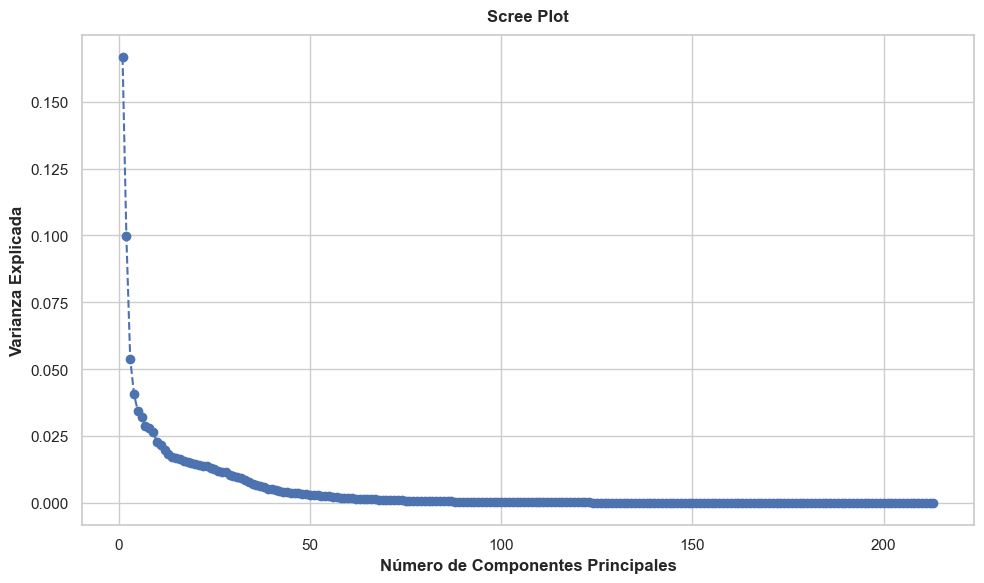

In [29]:
# Ajustar PCA y obtener la varianza explicada
pca = PCA()
pca.fit(X_scaled)  # X_scaled es el df estandarizado

# Crear el gráfico de scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.show()

3. **Varianza Acumulada**: Se calcula la varianza acumulada de los componentes principales y se determina el número de componentes necesarios para alcanzar un umbral de varianza acumulada del 95%.

In [30]:
variance_threshold=0.95  #Umbral de varianza acumulada deseada 95%

cumulative_variance = np.cumsum(pca.explained_variance_ratio_) #array con varianzas acumuladas
explained_variance_ratio = pca.explained_variance_ratio_# Obtener la varianza explicada por cada componente
num_components=np.argmax(cumulative_variance >= variance_threshold) + 1

4. **Gráfico de Varianza Acumulada**: Se crea un gráfico para mostrar la varianza acumulada por el número de componentes principales. Se añade una línea horizontal que representa el umbral de varianza acumulada y una línea vertical que indica el número de componentes necesarios para alcanzar este umbral.

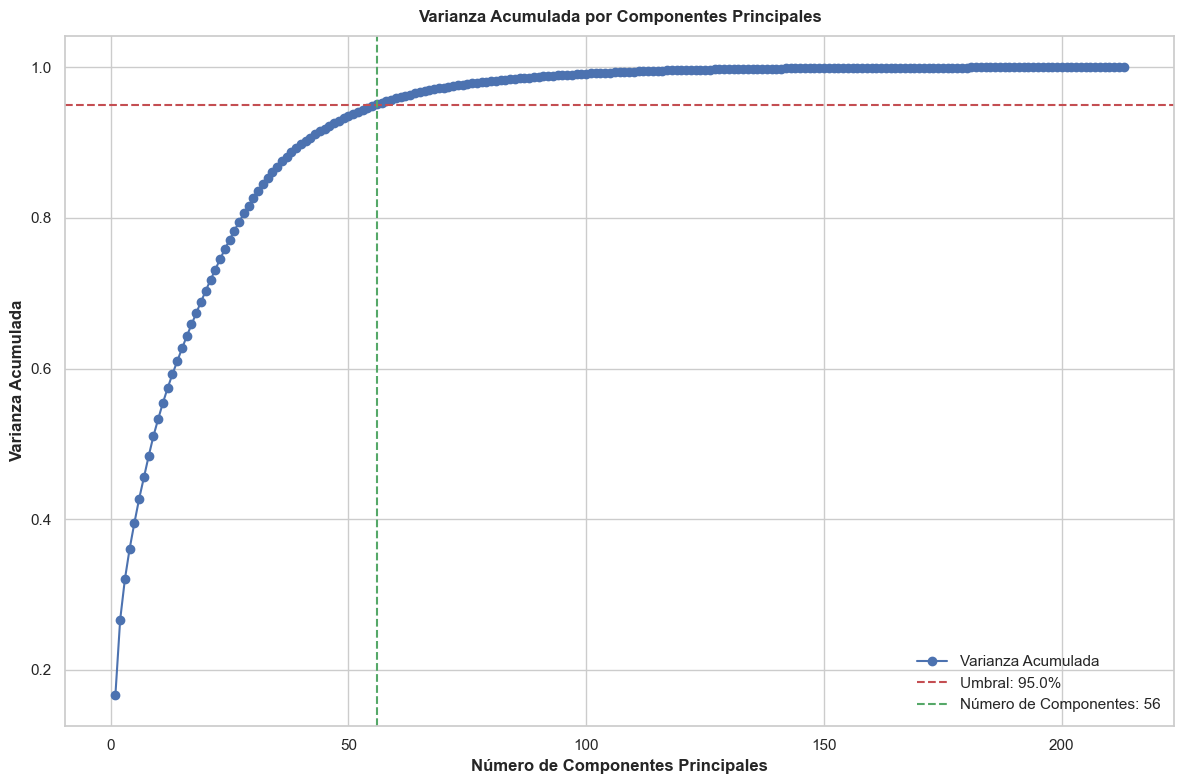

In [31]:
# Crear la gráfica
plt.figure(figsize=(12, 8))

# Plotear la varianza acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Varianza Acumulada')

# Añadir una línea horizontal en el umbral de varianza acumulada
plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'Umbral: {variance_threshold*100}%')

# Añadir un marcador para el número de componentes necesarios
plt.axvline(x=num_components, color='g', linestyle='--', label=f'Número de Componentes: {num_components}')

# Etiquetas y título
plt.title('Varianza Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

### Transformador Personalizado para PCA

Se define un transformador personalizado `PCAToDataFrameTransformer` para aplicar PCA y transformar los datos en un DataFrame con nombres de columna para los componentes principales:

- **Constructor (`__init__`)**: Inicializa el número de componentes principales a retener.
- **Método `fit`**: No realiza ninguna acción adicional en el ajuste.
- **Método `transform`**: Aplica PCA al conjunto de datos y genera un DataFrame con nombres de columna correspondientes a los componentes principales.

    ```python
    class PCAToDataFrameTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, n_components):
            self.n_components = n_components

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            # Perform PCA transformation
            pca = PCA(n_components=self.n_components)
            X_pca = pca.fit_transform(X)
            # Generate column names for PCA components
            column_names = [f'PC{i+1}' for i in range(self.n_components)]
            return pd.DataFrame(X_pca, columns=column_names)
    ```

Este proceso permite reducir la dimensionalidad del conjunto de datos y facilita la interpretación de las componentes principales al mostrar la varianza explicada y la varianza acumulada.

In [32]:
# Custom transformer to handle PCA output
class PCAToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Perform PCA transformation
        pca = PCA(n_components=self.n_components)
        X_pca = pca.fit_transform(X)
        # Generate column names for PCA components
        column_names = [f'PC{i+1}' for i in range(self.n_components)]
        return pd.DataFrame(X_pca, columns=column_names)

De 80 variables orginales y tras dumnificar/etiquetar las variables categoricas y escalar las numericas tenemos 57 componentes asegurando un 95% de la varianza explicada

# Creacion pipeline FINAL

# Preparación Final del Pipeline y Transformación PCA

### Combinación de Transformadores en un `ColumnTransformer`

Se combina un conjunto de transformadores en un `ColumnTransformer` para realizar la preprocesación de datos. Este `ColumnTransformer` incluye:

1. **Estandarización de Variables Numéricas**: Se aplica `StandardScaler` a las columnas numéricas.
2. **Codificación One-Hot**: Se usa `OneHotEncoder` para las variables categóricas, eliminando la primera categoría para evitar la multicolinealidad.
3. **Codificación de Etiquetas**: Se aplica `LabelEncodingTransformer` para las columnas de etiquetas.

In [33]:
# Combine all transformers into a single ColumnTransformer without using pipelines
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('one_hot', OneHotEncoder(drop='first', sparse_output=False), nom_var),
        ('label', LabelEncodingTransformer(), label_cols)
    ]
)

### Definición del Pipeline Final con PCA

Se define un pipeline que integra los pasos de preprocesamiento y PCA. Este pipeline incluye:

1. **Limpieza de Datos**: Se aplica `CleanTransformer` para limpiar los datos.
2. **Codificación**: Se usa `EncodeTransformer` para codificar las variables categóricas y ordinales.
3. **Imputación de Valores Faltantes**: Se aplica `ImputeTransformer` para manejar valores faltantes.
4. **Preprocesamiento de Datos**: Se utiliza el `ColumnTransformer` definido anteriormente para estandarizar, codificar y transformar las variables.
5. **PCA y Conversión a DataFrame**: Se aplica `PCAToDataFrameTransformer` para realizar PCA y convertir los datos transformados en un DataFrame con los componentes principales.

In [34]:
pipeline_preProcess_Standarized_pca = Pipeline([
    ('clean', CleanTransformer()),
    ('encode', EncodeTransformer(nominal_vars=nom_var, ordered_levels=ordered_levels)),
    ('impute', ImputeTransformer()),
    ('preprocessor', preprocessor_final),
    ('pca_to_df', PCAToDataFrameTransformer(n_components=56))  # Apply PCA and convert to DataFrame
])

### Aplicación del Pipeline y Guardado

El pipeline se aplica al DataFrame combinado, excluyendo la columna `SalePrice` para la transformación. Luego, se guarda el pipeline ajustado en un archivo `.pkl` para su uso futuro.

1. **Preparar los Datos**: Se crea una copia del DataFrame combinado y se elimina la columna `SalePrice`.
2. **Ajustar el Pipeline**: Se ajusta el pipeline al DataFrame preparado.

3. **Guardar el Pipeline**: Se guarda el pipeline ajustado en un archivo `.pkl` en la ruta especificada.

Este pipeline finaliza el proceso de preprocesamiento y reducción de dimensionalidad mediante PCA, y se asegura de que los datos estén listos para análisis adicionales o modelado.

In [35]:
df_combined_X=df_combined.copy()
df_combined=df_combined_X.drop('SalePrice',axis=1)

In [36]:
pipeline_preProcess_Standarized_pca.fit(df_combined_X.copy())
joblib.dump(pipeline_preProcess_Standarized_pca, codigo_dir/ 'pkls/pipeline_preProcess_Standarized_pca.pkl')

['c:\\Users\\Pc\\Desktop\\TFM_ENTREGA\\Anexos\\Codigo\\pkls\\pipeline_preProcess_Standarized_pca.pkl']

In [37]:
X_pca= pipeline_preProcess_Standarized_pca.transform(df_org.copy())
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56
0,2.775995,-0.342970,-0.704671,2.753893,-0.961969,1.741771,0.956175,0.379816,1.048577,0.083077,...,0.132080,-0.300856,-0.049487,0.166843,0.520691,-0.143337,0.349316,-0.222967,-0.184679,0.314755
1,0.407724,-3.468240,-0.464397,0.659505,-1.033812,0.500928,-0.473996,2.056493,0.046768,-1.730204,...,-0.759536,-0.059804,0.189837,-0.346681,-1.030042,-0.163551,0.037818,-0.399814,-1.045576,0.346446
2,3.292003,-0.704548,-0.243362,2.646208,0.689066,-0.830677,-0.456583,-1.283015,0.152096,-0.326755,...,0.114969,-0.269085,-0.075206,-0.359673,0.331655,-0.224750,0.023454,-0.123138,0.192543,0.240783
3,-0.349477,-1.934520,1.362800,0.848793,-1.396624,1.089920,-1.637626,1.525946,1.214422,-0.408532,...,0.479420,0.674894,-0.562460,1.059113,0.103722,-0.062197,-0.306119,0.159734,0.532458,-0.019317
4,5.483895,-0.600101,1.750299,2.006384,0.539243,0.498466,-1.070278,0.605281,1.359943,-0.106976,...,-0.268020,-0.128605,0.226361,0.113460,-0.380105,-0.380645,-0.093969,-0.338179,-0.268742,0.208185


# Evaluación de Modelos y Predicciones

Se separan los **datos en entrenamiento y test**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_scaled, test_size=0.2, random_state=randomSeed)

## Evaluación de Modelos

La función `model_eval` se utiliza para evaluar el rendimiento de los modelos de regresión. Dependiendo del parámetro `inverse`, se calcula y muestra el **R²** o el **MSE** junto con el **R²** en el conjunto de prueba.

```python
def model_eval(y_test, y_pred, inverse=False):
    if inverse:
        r2 = r2_score(y_test, y_pred)
        print(f'R² en el conjunto de prueba: {r2}')
    else:
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f'MSE en el conjunto de prueba: {mse}')
        print(f'R² en el conjunto de prueba: {r2}')


In [39]:
def model_eval(y_test,y_pred, inverse=False):

    if inverse:
        r2 = r2_score(y_test, y_pred)
        # Imprimir R² para el conjunto de prueba
        print(f'R² en el conjunto de prueba: {r2}')
    else:
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Imprimir MSE y R² para el conjunto de prueba
        print(f'MSE en el conjunto de prueba: {mse}')
        print(f'R² en el conjunto de prueba: {r2}')

La función `model_evaluation` realiza una evaluación en el conjunto de prueba y también ejecuta validación cruzada para obtener una visión más completa del rendimiento del modelo.

In [40]:
def model_evaluation(y_test, y_pred, model, X, y, cv=5):
    
    # Evaluación en el conjunto de prueba
    model_eval(y_test,y_pred)

    # Validación Cruzada
    mse_cv = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    r2_cv = cross_val_score(model, X, y, scoring='r2', cv=cv)
    
    # Convertir los resultados de MSE a valores positivos
    mse_cv = -mse_cv
    
    # Imprimir resultados de la validación cruzada
    print(f'\nValidación Cruzada:')
    print(f'MSE promedio (CV): {np.mean(mse_cv)} ± {np.std(mse_cv)}')
    print(f'R² promedio (CV): {np.mean(r2_cv)} ± {np.std(r2_cv)}')


XGBOOST

In [41]:
def XGBoost_model(X_train, X_test, y_train, y_test, params,X,y,model_path='pkls/XGBoost_model.pkl'):
    # Crear el modelo XGBoost con los parámetros especificados
    model = xgb.XGBRegressor(
        objective=params.get('objective', 'reg:squarederror'),
        n_estimators=params.get('n_estimators', 100),
        learning_rate=params.get('learning_rate', 0.1),
        max_depth=params.get('max_depth', 6),
        subsample=params.get('subsample', 0.8),
        colsample_bytree=params.get('colsample_bytree', 0.8),
        random_state=params.get('random_state', 13)
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    model_evaluation(y_test, y_pred,model,X,y)

    joblib.dump(model, model_path)

    return model

RANDOM FOREST

In [42]:
def RandomForest_model(X_train, X_test, y_train, y_test, params, X, y, cv=5, model_path='pkls/random_forest_model.pkl'):

    # Crear el modelo RandomForest con los parámetros especificados
    model = RandomForestRegressor(
        random_state=params.get('random_state', 13)
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    model_evaluation(y_test, y_pred, model, X.copy(), y.copy(), cv)

    joblib.dump(model, model_path)

    return model

LIGHTGBM

In [43]:
def LightGBM_model(X_train, X_test, y_train, y_test, params, X, y, cv=5, model_path='pkls/lightgbm_model.pkl'):
    # Crear el modelo LightGBM con los parámetros especificados
    model = lgb.LGBMRegressor(
        **params
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    model_evaluation(y_test, y_pred, model, X.copy(), y.copy(), cv)

    # Guardar el modelo entrenado
    joblib.dump(model, model_path)

    return model

Se definen los **parámetros para cada modelo** y se entrenan utilizando los conjuntos de entrenamiento y prueba. Los modelos entrenados se guardan en **archivos .pkl**.

In [44]:
paramsXGB = {
    'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': randomSeed
}

# Supongamos que X_train, X_test, y_train, y_test ya están definidos
modelXGB = XGBoost_model(X_train, X_test, y_train, y_test, paramsXGB, X_pca,y_scaled)

MSE en el conjunto de prueba: 0.35328051768229624
R² en el conjunto de prueba: 0.6544016889398994

Validación Cruzada:
MSE promedio (CV): 0.15086854914953862 ± 0.05574499553743356
R² promedio (CV): 0.8533565413646486 ± 0.04064350550674413


In [45]:
# Parámetros del modelo
paramsRF = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': True,
    'random_state': randomSeed
}

# Crear y entrenar el modelo RandomForest
modelRF = RandomForest_model(X_train, X_test, y_train, y_test, paramsRF, X_pca, y_scaled)

MSE en el conjunto de prueba: 0.3029934624792644
R² en el conjunto de prueba: 0.7035952347951022

Validación Cruzada:
MSE promedio (CV): 0.15946689964173552 ± 0.04628542293574499
R² promedio (CV): 0.8434216849047782 ± 0.027859859838578912


In [46]:
# Parámetros para LightGBM
paramsLGB = {
    'n_estimators': 100,        # Número de árboles
    'max_depth': -1,            # Sin límite de profundidad (None en sklearn)
    'min_child_samples': 1,     # Número mínimo de muestras en un nodo hoja (equivalente a min_samples_leaf en RF)
    'learning_rate': 0.1,       # Tasa de aprendizaje
    'num_leaves': 31,           # Número de hojas en un árbol
    'boosting_type': 'gbdt',    # Tipo de boosting (gradient boosting decision tree)
    'random_state': 13          # Semilla para la aleatoriedad
}

# Llamar a la función
modelLGB = LightGBM_model(X_train, X_test, y_train, y_test, paramsLGB, X_pca, y_scaled, cv=5, model_path='pkls/lightgbm_model.pkl')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 56
[LightGBM] [Info] Start training from score -0.011297
MSE en el conjunto de prueba: 0.2998566797506989
R² en el conjunto de prueba: 0.7066638071020801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 56
[LightGBM] [Info] Start training from score -0.002570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14280
[LightGBM] [Info] Nu